In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp
import matplotlib.ticker as tick
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import scipy.stats as stat
import numpy.linalg as la
import numpy.random as rd
import sklearn.linear_model as skl
import cvxpy as cvx
import IPython.display as disp
import joblib as jl
import time, h5py, warnings
import datetime as date
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import mean_squared_error as mse
from tqdm import tqdm, trange
from jupyterthemes import jtplot

In [3]:
jtplot.reset()
sns.set()
sns.set_context('talk')
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100
rd.seed(314)

In [22]:
"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
                    - mu_0: Gradient in the gradient ascent step, defaults to 2
                    - sigma_decrease: Amount by which the approximation parameter decreases each step
                    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10)

def get_frequency(ft, samprate):
    return np.argmax(abs(ft))/len(ft)*samprate

def rmse(K, I):
    return 1/(K.max() - K.min()) * np.sqrt(1/K.size * np.sum((I - K)**2))

def total_variation(x):
    assert len(x) == len(x.T), "Image is not square."
    tv = 0
    N = len(x)
    for i in range(N):
        for j in range(N):
            if i < (N - 1):
                Dh = x[i+1, j] - x[i,j]
            else:
                Dh = 0
            if j < (N - 1):
                Dv = x[i, j+1] - x[i,j]
            else:
                Dv = 0
            tv += np.sqrt(Dh**2 + Dv**2)
    return tv

def cosine_similarity(x, xhat):
    x, xhat = x.ravel(), xhat.ravel()
    A = x/x.max()
    B = xhat/xhat.max()
    assert len(A) == len(B), "Data coefficients and recovered coefficients are not of equal length"
    num = 0
    for i in range(len(A)):
        num += A[i]*B[i]
    den = la.norm(A, ord=2) * la.norm(B, ord=2)
    return num/den

def normalize(X):
    X = X.astype(float)
    X /= X.max()
    return X

In [5]:
class compsenseFromFile:
    
    def __init__(self, filename, downsample=False, downrate=None):
        self.rate, self.data = wav.read(filename)
        self.data = self.rescale_dtype(self.data, "i", np.int16)
        self.filename = filename
        self.name = filename[:-4]
        
        if len(self.data.shape) > 1 and self.data.shape[1] > 1:
            self.data = self.data.mean(axis=1)
            
        self.N = len(self.data)
        self.dur = self.N/self.rate
        self.t = np.linspace(0, self.dur, self.N)
        self.coef = fft.fft(self.data)
        self.coefshift = fft.fftshift(self.coef)
        
        if downsample:
            self.downrate = downrate
            self.Nd = int(downrate*self.dur)
            nd = np.round(np.linspace(0, self.N-1, self.Nd)).astype(int)
            self.data = self.data[nd]
            self.t = self.t[nd]
            self.coef = fft.fft(self.data)
            self.coefshift = fft.fftshift(self.coef)
            self.rate = downrate
        else:
            self.Nd = self.N
            self.t = np.linspace(0, self.dur, self.Nd)
        
    def getDominantFrequency(coef, rate):
        return np.argmax(abs(coef))/len(coef)*rate
        
    def displayOriginal(self, save=False):
        fig = mp.figure()

        f = np.linspace(0, self.rate, self.Nd)
        ax = fig.add_subplot(111)
        ax.plot(f[:self.Nd//2], abs(self.coef)[:self.Nd//2], "c-")
        ax.set_xlabel("frequency [s$^{-1}$]")
        ax.set_ylabel("amplitude [arb. units]")
        ax.set_title("original signal")
        
        in_ax = inset_axes(ax, width="40%", height="40%", loc=1)
        in_ax.plot(self.t, self.data, lw=0.4)
        in_ax.set_xlabel("time [s]")
        
        if save:
            mp.savefig(self.name + "_original.png", dpi=300, bbox_inches="tight")

        mp.show()
#         disp.Audio(self.data, rate=self.rate)
        
    def sampleCompressive(self, mode, rate):
        self.subrate = rate
        self.M = int(self.subrate*self.dur)
        
        if mode == "random":
            m = np.sort(rd.randint(0, self.Nd, self.M))
        elif mode == "subnyquist":
            m = np.round(np.linspace(0, self.Nd-1, self.M)).astype(int)
        else:
            raise ValueError("Specified mode is invalid")
        
        self.y = self.data[m]
        self.tm = self.t[m]
        self.compressedCoef = fft.fft(self.y)
        self.compressedCoefShift = fft.fftshift(self.compressedCoef)
        self.m = m
        
    def displayCompressed(self, save=False):
        fig = mp.figure()

        f = np.linspace(0, self.subrate, self.M)
        ax = fig.add_subplot(111)
        ax.plot(f[:self.M//2], abs(self.compressedCoef)[:self.M//2], "c-")
        ax.set_xlabel("frequency [s$^{-1}$]")
        ax.set_ylabel("amplitude [arb. units]")
        ax.set_title("compressively sampled signal")

        in_ax = inset_axes(ax, width="40%", height="40%", loc=1)
        in_ax.plot(self.tm, self.y, lw=0.4)
#         in_ax.set_xlabel("time [s]")
        
        if save:
            mp.savefig(self.name + "_comp.png", dpi=300, bbox_inches="tight")
#             wav.write(self.name + "_comp.wav", self.subrate, self.y)
        
        mp.show()
#         disp.Audio(y, rate=self.subrate)
    
    def recovery(self, method, **method_kwargs):
        self.method = method
        d = fft.dct(np.identity(self.Nd))
        A = d[self.m]
        
        if method == "LASSO":
            prob = skl.Lasso(**method_kwargs)
        elif method == "LASSOCV":
            prob = skl.LassoCV(**method_kwargs)
        elif method == "OMP":
            prob = skl.OrthogonalMatchingPursuit(**method_kwargs)
        elif method == "SL0":
            prob = SL0(A, self.y)
            self.recoveredCoef = prob
            self.xhat = fft.idct(self.recoveredCoef)
            self.xhat = self.rescale_dtype(self.xhat, "i", np.int16)
            return
        else:
            raise ValueError("Specified method is invalid")
        
        prob.fit(A, self.y)
        self.recoveredCoef = prob.coef_
        self.xhat = fft.idct(self.recoveredCoef)
        self.xhat = self.rescale_dtype(self.xhat, "i", np.int16)
            
    def displayRecovered(self, save):
        fig = mp.figure()

        ax = fig.add_subplot(111)
        f = np.linspace(0, self.rate/2, self.Nd)
        ax.plot(f[:self.Nd//2], abs(self.recoveredCoef)[:self.Nd//2], "c-")
        ax.set_xlabel("frequency [s$^{-1}$]")
        ax.set_ylabel("amplitude [arb. units]")
        ax.set_title("reconstructed signal")

        in_ax = inset_axes(ax, width="35%", height="35%", loc=1)
        in_ax.plot(self.t, self.xhat, lw=0.4)
#         in_ax.set_xlabel("time [s]")

        if save:
            mp.savefig(self.name + "_recon_" + self.method + ".png", dpi=300, bbox_inches="tight")
#             wav.write(self.name + "_recon_" + self.method + ".wav", self.rate, xhat)

        mp.show()
#         disp.Audio(self.y, rate=self.rate)
    
    def rescale_dtype(self, data, ttype, ttarget):
        if ttype == "i":
            tmax = np.iinfo(ttarget).max
            return np.round(data/data.max() * tmax).astype(ttarget)
        elif ttype == "f":
            tmax = np.finfo(ttarget).max
            return (data/data.max()).astype(ttarget)
        else:
            raise("TypeError: invalid ttype")
    
    def get_psnr(self):
        return 20*np.log10(np.iinfo(np.int16).max/np.sqrt(mse(self.data, self.xhat)))
    
    def get_cossim(self):
        A = self.data/self.data.max()
        B = self.xhat/self.xhat.max()
        assert len(A) == len(B), "Data coefficients and recovered coefficients are not of equal length"
        num = 0
        for i in range(len(A)):
            num += A[i]*B[i]
        den = la.norm(A, ord=2) * la.norm(B, ord=2)
        return num/den
        
    def run_all(self, mode, rate, save, method, **method_kwargs):
        self.displayOriginal(save)
        self.sampleCompressive(mode, rate)
        self.displayCompressed(save)
        self.recovery(method, **method_kwargs)
        self.displayRecovered(save)

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


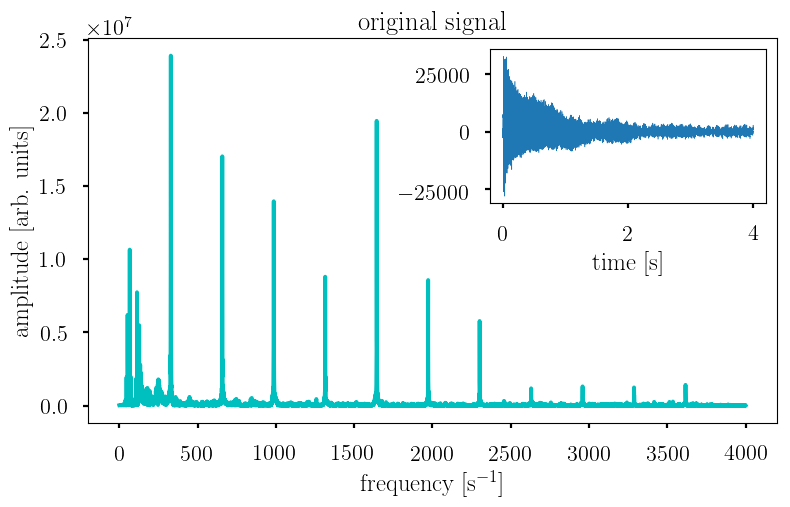

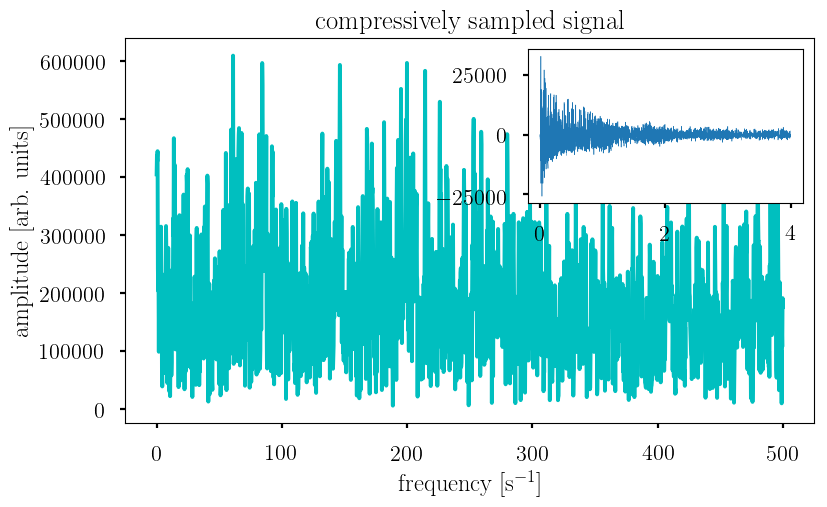

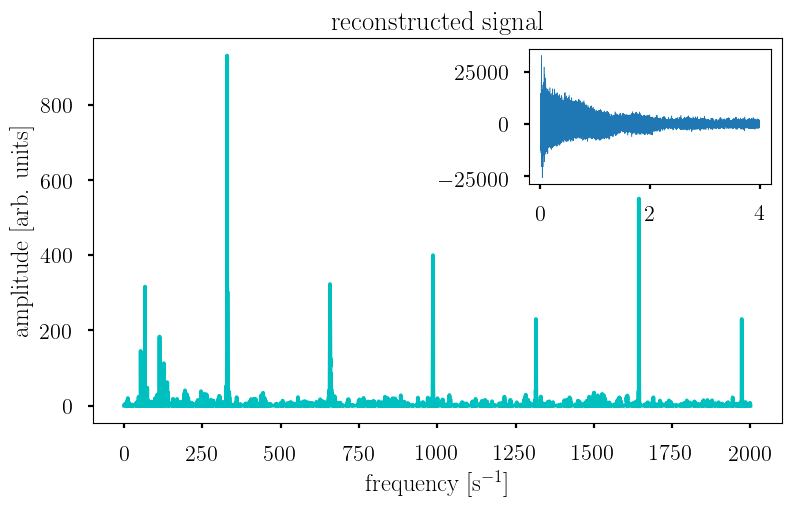

In [6]:
E1 = compsenseFromFile("E1.wav")
E1.run_all("random", 1000, True, "LASSO", alpha=1.0)
# np.save("E1_origsig.npy", E1.data)
# np.save("E1_origcoef.npy", E1.coef)
# np.save("E1_compsig.npy", E1.y)
# np.save("E1_compcoef.npy", E1.compressedCoef)
# np.save("E1_recovsig.npy", E1.xhat)
# np.save("E1_recovcoef.npy", E1.recoveredCoef)

In [7]:
data = np.load("E1_origsig.npy")
coef = np.load("E1_origcoef.npy")
y = np.load("E1_compsig.npy")
compressedCoef = np.load("E1_compcoef.npy")
xhat = np.load("E1_recovsig.npy")
recoveredCoef = np.load("E1_recovcoef.npy")
rate = 8000
Nd = len(data)
M = len(y)
dur = Nd/rate
t = np.linspace(0, dur, Nd)
tm = np.linspace(0, dur, M)
subrate = 1000

In [26]:
cosine_similarity(normalize(data), normalize(xhat))

0.929613766971544

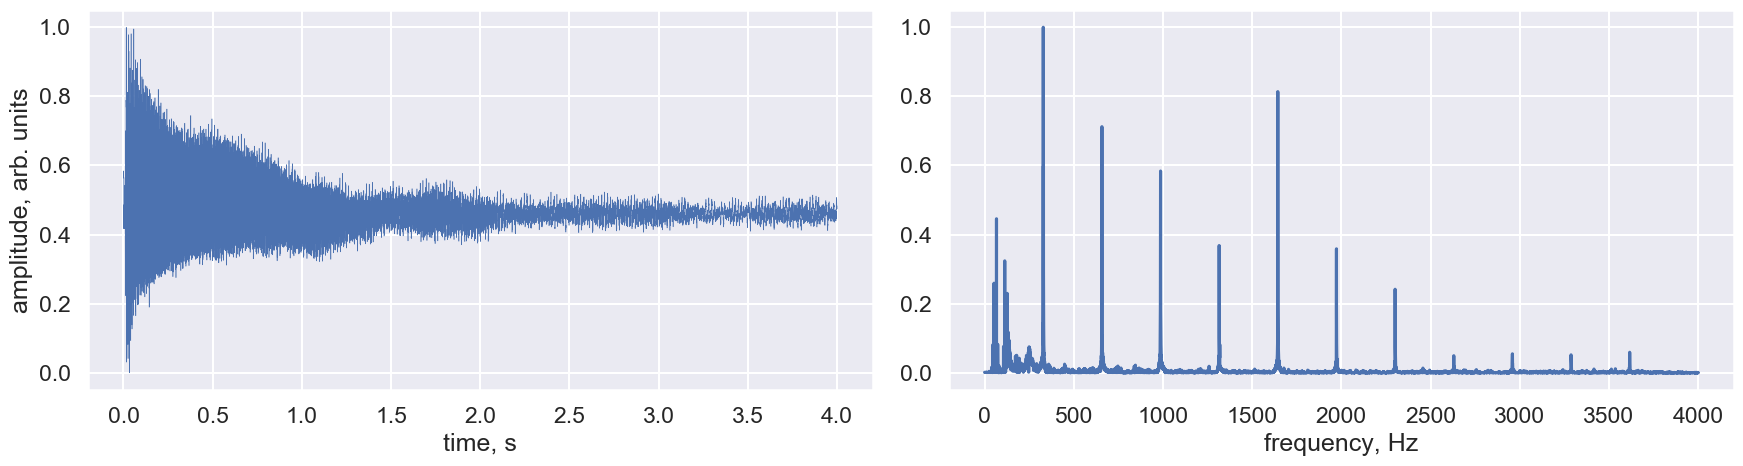

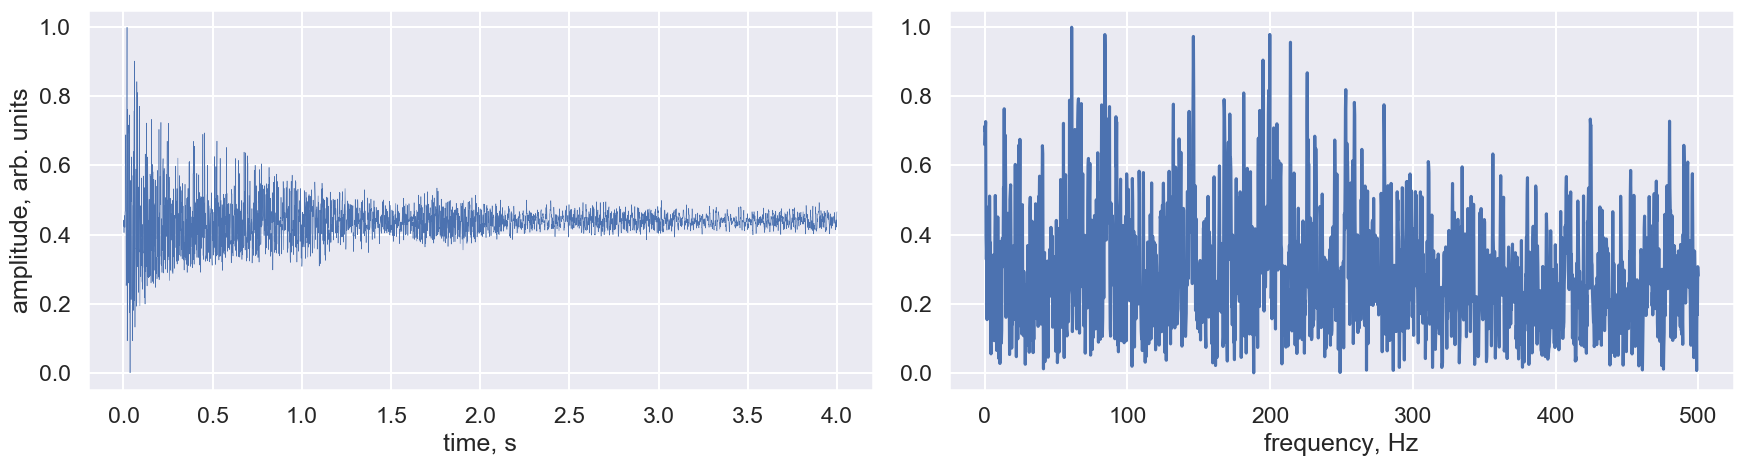

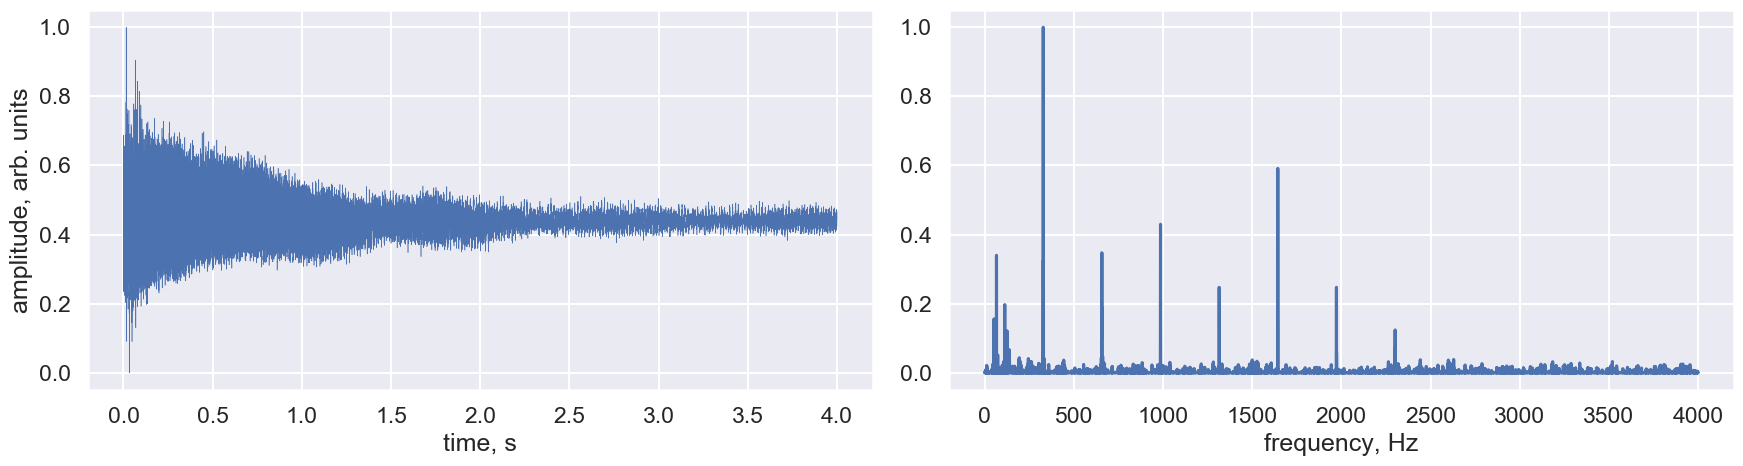

In [8]:
fig = mp.figure(figsize=(5*16/9*2, 5))
f = np.linspace(0, rate, Nd)
ax = fig.add_subplot(121)
ax.plot(t, normalize(data), lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude, arb. units")

ax = fig.add_subplot(122)
ax.plot(f[:Nd//2], normalize(abs(coef)[:Nd//2]))
ax.set_xlabel("frequency, Hz")
# ax.set_ylabel("amplitude, arb. units")
# ax.set_title("original signal")
mp.savefig("orig.png", dpi=300, bbox_inches="tight")
mp.tight_layout()
mp.show()


fig = mp.figure(figsize=(5*16/9*2, 5))
f = np.linspace(0, subrate, M)
ax = fig.add_subplot(121)
ax.plot(tm, normalize(y), lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude, arb. units")

ax = fig.add_subplot(122)
ax.plot(f[:M//2], normalize(abs(compressedCoef)[:M//2]))
ax.set_xlabel("frequency, Hz")
# ax.set_ylabel("amplitude, arb. units")
# ax.set_title("compressively sampled signal")
mp.savefig("comp.png", dpi=300, bbox_inches="tight")
mp.tight_layout()
mp.show()


fig = mp.figure(figsize=(5*16/9*2, 5))
ax = fig.add_subplot(121)
ax.plot(t, normalize(xhat), lw=0.4)
ax.set_xlabel("time, s")
ax.set_ylabel("amplitude, arb. units")
ax = fig.add_subplot(122)
f = np.linspace(0, rate/2, Nd)

ax.plot(f, normalize(abs(recoveredCoef)))
ax.set_xlabel("frequency, Hz")
# ax.set_ylabel("amplitude, arb. units")
# ax.set_title("reconstructed signal")
mp.savefig("recov.png", dpi=300, bbox_inches="tight")
mp.tight_layout()

mp.show()

In [13]:
maxiters = 5
percentSamples = np.arange(0.1, 0.51, 0.1)
processTime_lasso = np.zeros((maxiters, len(percentSamples)), float)
processTime_omp = np.zeros_like(processTime_lasso, float)
processTime_sl0 = np.zeros_like(processTime_lasso, float)
mseList_lasso = np.zeros((maxiters, len(percentSamples)), float)
mseList_omp = np.zeros_like(mseList_lasso, float)
mseList_sl0 = np.zeros_like(mseList_lasso, float)
csimList_lasso = np.zeros((maxiters, len(percentSamples)), float)
csimList_omp = np.zeros_like(csimList_lasso, float)
csimList_sl0 = np.zeros_like(csimList_lasso, float)
methodList = ["LASSO", "OMP", "SL0"]

In [15]:
rd.seed(402)
pbar = tqdm(methodList)
start_time = time.time()
for m,t in enumerate(pbar):
    pbar.set_description("Using algorithm %s" %t)
    
    if m == 0:
        continue
    
    for k in trange(maxiters, desc="Stochastic iteration"):
    #     print("{0}: iteration {1}/{2}".format(date.datetime.now(), k+1, maxiters))
        
        for s in trange(len(percentSamples), desc="percentage of samples", leave=False):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                E1L = compsenseFromFile("E1.wav")
    #         if i == 0:
    #             print("{0}: Process start".format(date.datetime.now()))
            t0 = time.time()
            if m == 0:
                E1L.run_all("random", (percentSamples[s]*len(E1L.data))//32, False, methodList[m], alpha=1.0)
            else:
                E1L.run_all("random", (percentSamples[s]*len(E1L.data))//32, False, methodList[m])
            t1 = time.time()
    #         hours, rem = divmod(t1-t0, 3600)
    #         minutes, seconds = divmod(rem, 60)
    #         print("{0}: LASSO, {1} ({2}%) samples, {3:0>2}:{4:0>2}:{5:05.2f} elapsed, {6:.2f}% done".format(date.datetime.now(), 
    #                                                     int(s*len(E1L.data)), int(s*100), int(hours), int(minutes), seconds, 100*i/len(percentSamples)))
            
            if m == 0:
                mseList_lasso[k,s] = mse(E1L.data, E1L.xhat)
                processTime_lasso[k,s] = t1-t0
                csimList_lasso[k,s] = E1L.get_cossim()
            elif m == 1:
                mseList_omp[k,s] = mse(E1L.data, E1L.xhat)
                processTime_omp[k,s] = t1-t0
                csimList_omp[k,s] = E1L.get_cossim()
            else:
                mseList_sl0[k,s] = mse(E1L.data, E1L.xhat)
                processTime_sl0[k,s] = t1-t0
                csimList_sl0[k,s] = E1L.get_cossim()

    #         if s == len(percentSamples):
    #             print("{0}: LASSO, {1} ({2}%) samples, {3:0>2}:{4:0>2}:{5:05.2f} elapsed, {6:.2f}% done".format(date.datetime.now(), 
    #                                                     int(s*len(E1L.data)), int(s*100), int(hours), int(minutes), seconds, 100*i/len(percentSamples)))
#             np.save("timelasso.npy", processTime_lasso)
            np.save("timeomp.npy", processTime_omp)
            np.save("timesl0.npy", processTime_sl0)
#             np.save("csimlasso.npy", csimList_lasso)
            np.save("csimomp.npy", csimList_omp)
            np.save("csimsl0.npy", csimList_sl0)
#             np.save("mselasso.npy", mseList_lasso)
            np.save("mseomp.npy", mseList_omp)
            np.save("msesl0.npy", mseList_sl0)
    
end_time = time.time()
# np.save("timelasso.npy", processTime_lasso)
np.save("timeomp.npy", processTime_omp)
np.save("timesl0.npy", processTime_sl0)
# np.save("csimlasso.npy", csimList_lasso)
np.save("csimomp.npy", csimList_omp)
np.save("csimsl0.npy", csimList_sl0)
# np.save("mselasso.npy", mseList_lasso)
np.save("mseomp.npy", mseList_omp)
np.save("msesl0.npy", mseList_sl0)

hours, rem = divmod(end_time-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{0}: Done. Total time: {1:0>2}:{2:0>2}:{3:05.2f}".format(date.datetime.now(), int(hours), int(minutes), seconds))







  0%|                                                    | 0/3 [00:00<?, ?it/s]





Using algorithm LASSO:   0%|                             | 0/3 [00:00<?, ?it/s]





Using algorithm OMP:   0%|                               | 0/3 [00:00<?, ?it/s]






Stochastic iteration:   0%|                              | 0/5 [00:00<?, ?it/s]







percentage of samples:   0%|                             | 0/5 [00:00<?, ?it/s]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)








percentage of samples:  20%|████▏                | 1/5 [00:38<02:35, 38.94s/it]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dicti









percentage of samples:  80%|████████████████▊    | 4/5 [04:26<01:08, 68.07s/it]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_path=return_path)








percentage of samples: 100%|████████████████████| 5/5 [07:27<00:00, 101.84s/it]







                                                                               






Stochastic iteration:  80%|████████████████▊    | 4/5 [30:40<07:48, 468.27s/it]







percentage of samples:   0%|                             | 0/5 [00:00<?, ?it/s]C:\Users\Porites\Anaconda3\envs\compsense\lib\site-packages\sklearn\linear_model\omp.py:387: RuntimeWarning:  Orthogonal matching pursuit ended prematurely due to linear
dependence in the dictionary. The requested precision might not have been met.

  copy_X=copy_X, return_

2019-05-16 22:25:59.860708: Done. Total time: 01:03:04.31


In [14]:
processTime_lasso = np.load("timelasso.npy")
processTime_omp = np.load("timeomp.npy")
processTime_sl0 = np.load("timesl0.npy")
csimList_lasso = np.load("csimlasso.npy")
csimList_omp = np.load("csimomp.npy")
csimList_sl0 = np.load("csimsl0.npy")
mseList_lasso = np.load("mselasso.npy")
mseList_omp = np.load("mseomp.npy")
mseList_sl0 = np.load("msesl0.npy")

In [15]:
MSEall = np.array([mseList_lasso, mseList_omp, mseList_sl0])
TIMEall = np.array([processTime_lasso, processTime_omp, processTime_sl0])
CSIMall = np.array([csimList_lasso, csimList_omp, csimList_sl0])

In [16]:
mMSE = np.zeros(MSEall[:,0,:].shape, float)
sdMSE = np.zeros_like(mMSE)
mTIME = np.zeros_like(mMSE)
sdTIME = np.zeros_like(mMSE)
mCSIM = np.zeros_like(mMSE)
sdCSIM = np.zeros_like(mMSE)

for i in range(3):
    mMSE[i] = MSEall[i].mean(axis=0)
    sdMSE[i] = MSEall[i].std(axis=0)
    sdomMSE = sdMSE/len(mMSE.T)
    
    mTIME[i] = TIMEall[i].mean(axis=0)
    sdTIME[i] = TIMEall[i].std(axis=0)
    sdomTIME = sdTIME/len(mTIME.T)
    
    mCSIM[i] = CSIMall[i].mean(axis=0)
    sdCSIM[i] = CSIMall[i].std(axis=0)
    sdomCSIM = sdCSIM/len(mCSIM.T)

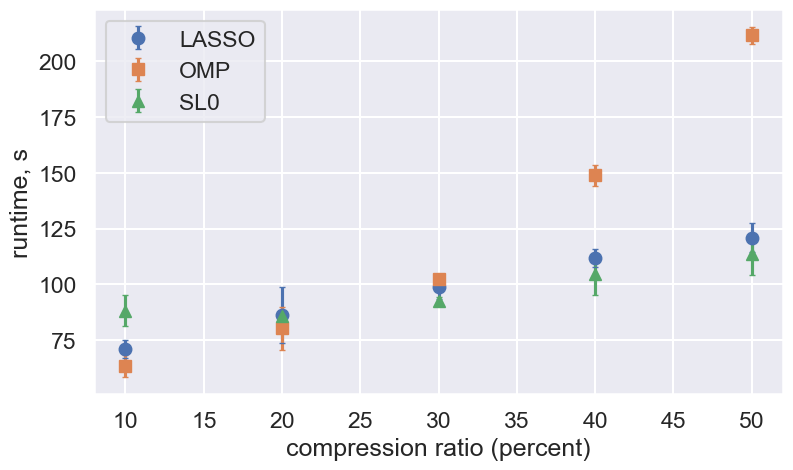

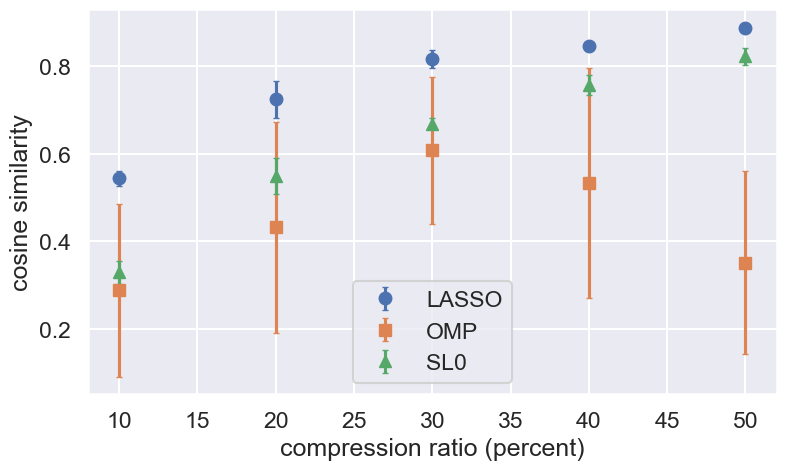

In [18]:
markerlist = ["o", "s", "^"]
colorlist = ["#5daecc", "#8edddd", "#efca3a"]

mp.figure(figsize=(5*16/9, 5))
for i in range(3):
    mp.errorbar((percentSamples*100).astype(int), mTIME[i], sdTIME[i], None, markerlist[i], label=methodList[i], capsize=2)
mp.xlabel("compression ratio (percent)")
mp.ylabel("runtime, s")
mp.legend()
mp.savefig("E1_processtime.png", dpi=300, bbox_inches="tight")
mp.show()

mp.figure(figsize=(5*16/9, 5))
for i in range(3):
    mp.errorbar((percentSamples*100).astype(int), mCSIM[i], sdCSIM[i], None, markerlist[i], label=methodList[i], capsize=2)
mp.xlabel("compression ratio (percent)")
mp.ylabel("cosine similarity")
mp.legend()
mp.savefig("E1_cossim.png", dpi=300, bbox_inches="tight")
mp.show()